# Cats vs dogs CNN Classifier using PyTorch

This notebook is a simple example of how to use PyTorch to build a Convolutional Neural Network (CNN) to classify images of cats and dogs. The dataset used is the [Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) dataset from Kaggle. The dataset consists of 25,000 labelled dog and cat images. The images are of various sizes and are not of fixed dimensions.

The CNN model used in this notebook is a deep CNN model with 4 convolutional layers and 3 fully connected layers. The model is trained on 20,000 images and validated on 5,000 images.

First, we'll start by importing the necessary libraries.

In [39]:
import torch 
import os
import random
import imagesize
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from pathlib import Path

Now, we will visualize the images in the dataset to get an idea of what the images look like.

In [24]:
images_path = Path('../data/cats_dogs')
images = [img_file for img_file in images_path.glob('*.jpg')]

images_meta = {}
for img_name in images:
    images_meta[img_name] = imagesize.get(img_name)

images_df = pd.DataFrame.from_dict([images_meta]).T.reset_index().set_axis(['FileName', 'Size'], 
                                                                             axis='columns')
images_df[["Width", "Height"]] = pd.DataFrame(images_df["Size"].tolist(), index=images_df.index)
images_df["Aspect Ratio"] = round(images_df["Width"] / images_df["Height"], 2)
images_df["Label"] = [img.stem.split('.')[0] for img in images]

print(f'Total nr of images: {len(images_df)}')
images_df.head()

Total nr of images: 25000


,FileName,Size,Width,Height,Aspect Ratio,Label
0,..\data\cats_dogs\cat.0.jpg,"(500, 374)",500,374,1.34,cat
1,..\data\cats_dogs\cat.1.jpg,"(300, 280)",300,280,1.07,cat
2,..\data\cats_dogs\cat.10.jpg,"(489, 499)",489,499,0.98,cat
3,..\data\cats_dogs\cat.100.jpg,"(403, 499)",403,499,0.81,cat
4,..\data\cats_dogs\cat.1000.jpg,"(150, 149)",150,149,1.01,cat


Visualize image resolution distribution.

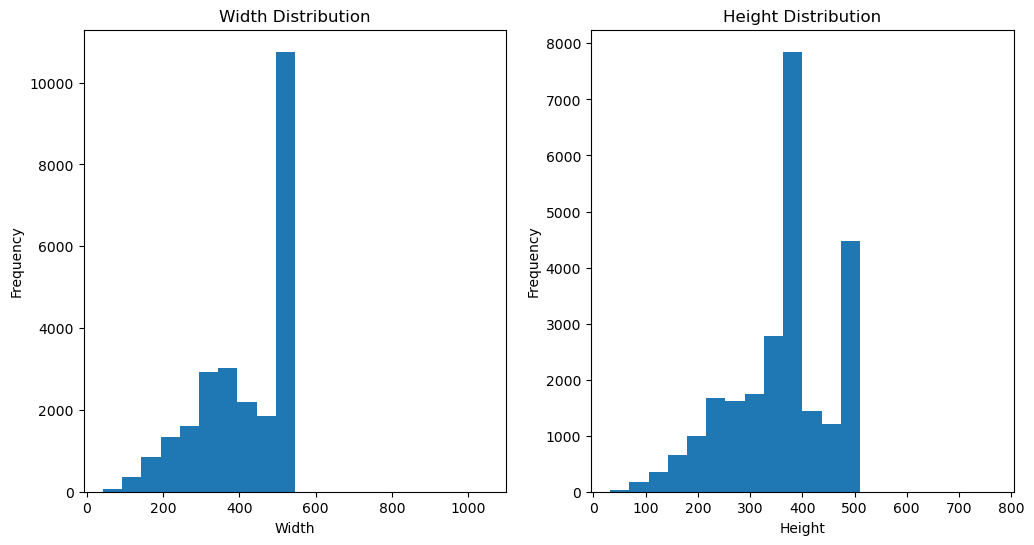

In [25]:
# visualize the width and height distribution using bar plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
images_df["Width"].plot(kind='hist', bins=20, ax=ax[0])
ax[0].set_title('Width Distribution')
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Frequency')

images_df["Height"].plot(kind='hist', bins=20, ax=ax[1])
ax[1].set_title('Height Distribution')  
ax[1].set_xlabel('Height')
ax[1].set_ylabel('Frequency')

plt.show()

We can see that the majotiory of the images have a resolution of around 300x300 pixels. We will resize all of the images to that resolution. Let's define the dataset class and the data loaders.

In [26]:
class CatsDogsDataset(Dataset):
    def __init__(self, tensor_dir, transform=None, target_transform=None):
        self.tensor_dir = tensor_dir
        self.tensor_files = os.listdir(tensor_dir)
        self.transform = transform
        self.target_transform = target_transform 

    def __len__(self):
        return len(self.tensor_files)
    
    def __getitem__(self, idx):
        tensor_path = os.path.join(self.tensor_dir, self.tensor_files[idx])
        tensor = torch.load(tensor_path)
        label = self.tensor_files[idx].split('.')[0]
        
        if self.transform:
            tensor = self.transform(tensor)

        if self.target_transform:
            label = self.target_transform(label)

        return tensor, label

In [27]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

target_transform = lambda label: \
                    torch.tensor([1, 0], dtype=torch.float32) if label == 'dog' else torch.tensor([0, 1], dtype=torch.float32)

train_tensors_dir = '../data/cats_dogs/tensors/train'
test_tensors_dir = '../data/cats_dogs/tensors/test'

train_dataset = CatsDogsDataset(train_tensors_dir, transform=transform, target_transform=target_transform)
test_dataset = CatsDogsDataset(test_tensors_dir, transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [28]:
class CatsDogsCNN(nn.Module):
    def __init__(self):
        super(CatsDogsCNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 37 * 37, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.conv_stack(x)
    

model = CatsDogsCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    size = len(train_loader)
    running_loss = 0.0
    for batch, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch % 100 == 99:
            loss, current = loss.item(), batch + 1
            print(f" [{current}/{size}] loss: {loss:>7f}")

    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (X, y) in test_loader:
            inputs, labels = X.to(device), y.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), correct / total

In [31]:
epochs = 10

train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n' + '-' * 45)
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'\nTrain Loss: {train_loss}, Test Loss: {test_loss}, Accuracy: {accuracy * 100}%\n')

    if len(test_losses) > 1 and test_losses[-2] < test_losses[-1]:
        print('Test loss has increased. Stopping training...')
        break

Epoch 1
---------------------------------------------
 [100/400] loss: 0.528513
 [200/400] loss: 0.516666
 [300/400] loss: 0.595814
 [400/400] loss: 0.649406

Train Loss: 0.544171791523695, Test Loss: 0.5039922460913658, Accuracy: 74.74%

Epoch 2
---------------------------------------------
 [100/400] loss: 0.563211
 [200/400] loss: 0.453661
 [300/400] loss: 0.531078
 [400/400] loss: 0.444280

Train Loss: 0.4652562993019819, Test Loss: 0.4607957437634468, Accuracy: 78.25999999999999%

Epoch 3
---------------------------------------------
 [100/400] loss: 0.355444
 [200/400] loss: 0.282909
 [300/400] loss: 0.456664
 [400/400] loss: 0.258239

Train Loss: 0.38467949740588664, Test Loss: 0.44100928455591204, Accuracy: 79.4%

Epoch 4
---------------------------------------------
 [100/400] loss: 0.378705
 [200/400] loss: 0.151402
 [300/400] loss: 0.136286
 [400/400] loss: 0.156636

Train Loss: 0.24836357085034252, Test Loss: 0.551861238181591, Accuracy: 79.75999999999999%

Test loss has in

Now, let's plot some statistics about the dataset.

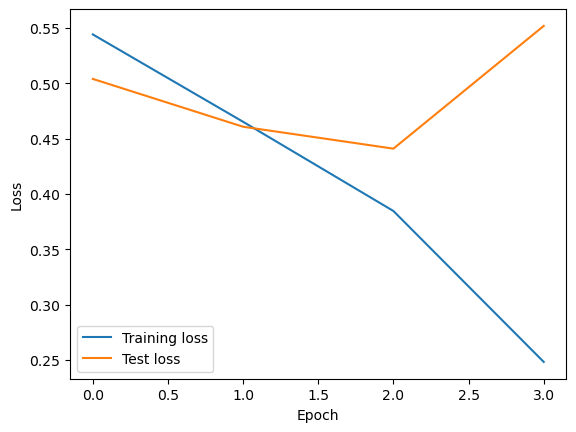

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

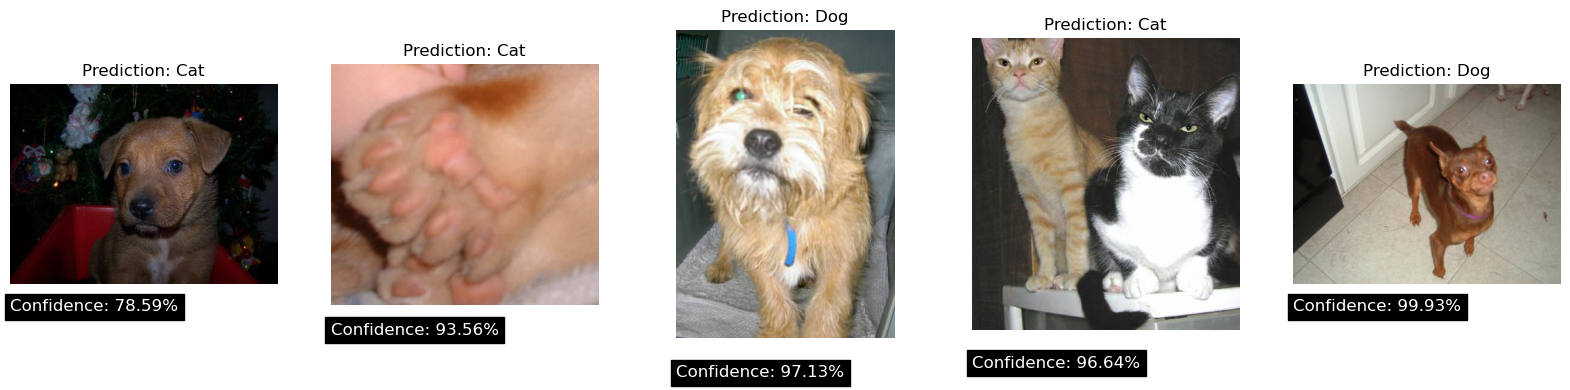

In [68]:
# read 5 images and make predictions for them
model.eval()

def predict_image(model, image_path, device):
    image = Image.open(image_path).resize((300, 300))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    predicted_prob, predicted = torch.max(output, 1)
    return predicted, predicted_prob

random.shuffle(images)

fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for i, img_path in enumerate(images[:5]):
    prediction, confidence = predict_image(model, img_path, device)
    label = 'Dog' if prediction == 0 else 'Cat'
    ax[i].imshow(Image.open(img_path))
    img_width, img_height = imagesize.get(img_path)
    ax[i].set_title(f'Prediction: {label}')
    # add confidence to the bottom
    ax[i].text(0, img_height + 50, f'Confidence: {round(confidence.item() * 100, 2)}%', fontsize=12, color='white', backgroundcolor='black')
    ax[i].axis('off')

plt.show()